<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Flow

Based on (Horn, B., Schunk, B., *Determining Optical Flow* 1981).

## 1. Estimating partial derivatives

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def image_seq_partial(arr):
  # Pad the lower-right boundary of each frame, and pad the back frame.
  padded = np.pad(arr, ((0, 1), (0, 1), (0, 1)), mode='edge')

  # Shift the entire array to get 8 neighbouring measurements.
  # Roll does the trick since we will ignore values in the padded boundary.
  shift000 = padded
  shift001 = np.roll(padded, -1, axis=2)
  shift010 = np.roll(padded, -1, axis=1)
  shift011 = np.roll(padded, (-1, -1), axis=(1, 2))
  shift100 = np.roll(padded, -1, axis=0)
  shift101 = np.roll(padded, (-1, -1), axis=(0, 2))
  shift110 = np.roll(padded, (-1, -1), axis=(0, 1))
  shift111 = np.roll(padded, (-1, -1, -1), axis=(0, 1, 2))

  # Approximate derivatives.
  partial_x = 0.25 * (shift010 - shift000 + shift110 - shift100 + shift011 - shift001 + shift111 - shift101)
  partial_y = 0.25 * (shift100 - shift000 + shift110 - shift010 + shift101 - shift001 + shift111 - shift011)
  partial_t = 0.25 * (shift001 - shift000 + shift101 - shift100 + shift011 - shift010 + shift111 - shift110)

  # Concatenate and return at positions available in arr.
  return np.stack((
      partial_x[:-1, :-1, :-1],
      partial_y[:-1, :-1, :-1],
      partial_t[:-1, :-1, :-1]
  ), axis=0)

In [9]:
im_arr = np.stack([np.array([
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ]),
    np.array([
        [0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ]),
    np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ])
], axis=-1)

In [10]:
partial = image_seq_partial(im_arr)

In [11]:
partial.shape

(3, 6, 6, 3)

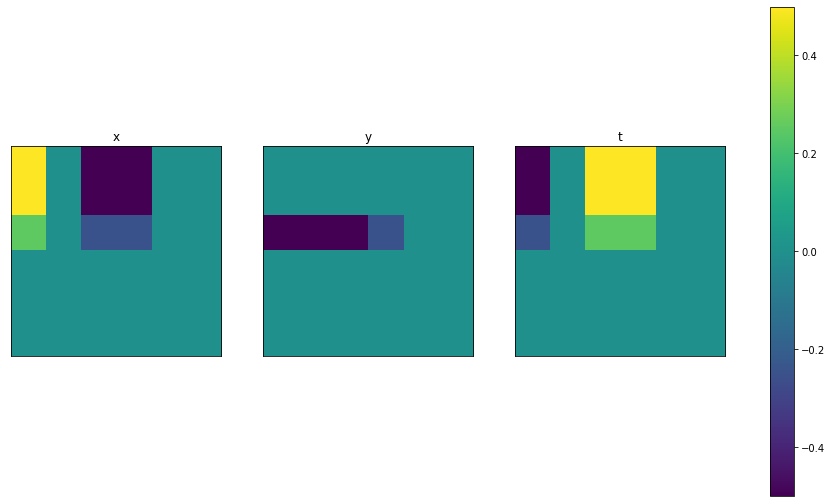

In [12]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(partial[0, :, :, 0], vmin=-0.5, vmax=0.5)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_aspect('equal')
ax1.set_title('x')
plt.margins(0.25, 0.25)

ax2 = fig.add_subplot(132)
ax2.imshow(partial[1, :, :, 0], vmin=-0.5, vmax=0.5)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_aspect('equal')
ax2.set_title('y')
plt.margins(0.25, 0.25)

ax3 = fig.add_subplot(133)
ax3.imshow(partial[2, :, :, 0], vmin=-0.5, vmax=0.5)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_aspect('equal')
ax3.set_title('t')
plt.margins(0.25, 0.25)

fig.colorbar(im1, ax=(ax1, ax2, ax3))
plt.show()

## 2. Estimating the Laplacian of the flow velocities

In [13]:
from scipy.signal import convolve2d

In [14]:
def image_seq_laplacian(arr):
  # Pad all spatial boundaries.
  if len(arr.shape) == 2:
    arr_new = np.expand_dims(arr, axis=-1)
  elif len(arr.shape) == 3:
    arr_new = arr
  else:
    raise ValueError('Wrong input dimension. Must be 2 or 3.')
  padded = np.pad(arr_new, ((1, 1), (1, 1), (0, 0)), mode='edge')

  # Convolution kernel.
  kernel = np.array([
      [0.25, 0.5, 0.25],
      [0.5, -3.0, 0.5],
      [0.25, 0.5, 0.25]
  ])

  # Convolve each frame of padded with kernel and discard boundary.
  lap = np.zeros_like(arr_new, dtype='float')
  for f in range(arr_new.shape[-1]):
    lap[..., f] += convolve2d(padded[..., f], kernel, mode='valid')
  
  return lap

In [15]:
u_test = np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 0, -1, -1, -1],
    [0, 0, 0, -1, -1, -1],
    [0, 0, 0, -1, -1, -1]
])

In [16]:
lap_u = image_seq_laplacian(u_test)

In [17]:
v_test = np.array([
    [-1, -1, -1, 0, 0, 0],
    [-1, -1, -1, 0, 0, 0],
    [-1, -1, -1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1]
])

In [18]:
lap_v = image_seq_laplacian(v_test)

In [19]:
lap_v.shape

(6, 6, 1)

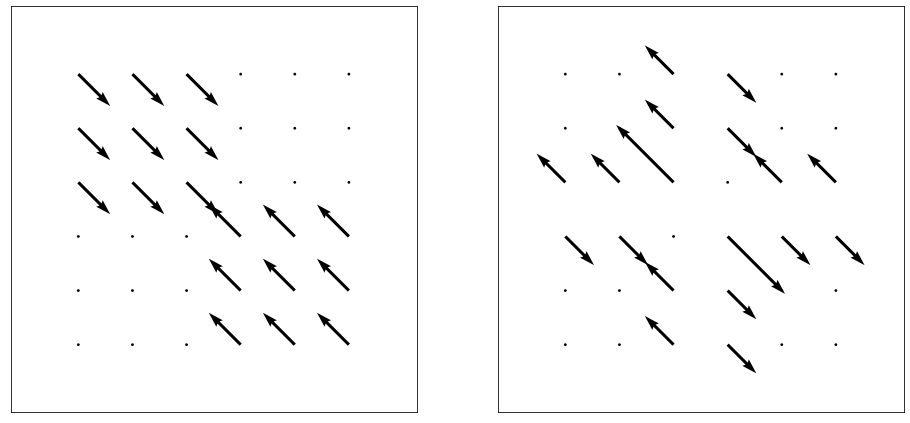

In [46]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_aspect('equal')
plt.quiver(u_test[::-1], v_test[::-1])
plt.margins(0.25, 0.25)

ax2 = fig.add_subplot(122)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_aspect('equal')
plt.quiver(lap_u[::-1, :, 0], lap_v[::-1, :, 0])
plt.margins(0.25, 0.25)
plt.show()

## 3. Local averages

Estimate local averages in a single frame.

In [22]:
def image_local_averages(arr):
  if len(arr.shape) != 2:
    raise ValueError('Wrong dimension. Must be 2.')
  # Pad all spatial boundaries.
  padded = np.pad(arr, ((1, 1), (1, 1)), mode='edge')

  # Convolution kernel.
  kernel = 1/3 * np.array([
      [0.25, 0.5, 0.25],
      [0.5, 0.0, 0.5],
      [0.25, 0.5, 0.25]
  ])

  # Convolve padded with kernel and discard boundary.
  loc = convolve2d(padded, kernel, mode='valid')
  
  return loc

In [23]:
loc_u = image_local_averages(u_test)

In [24]:
loc_v = image_local_averages(v_test)

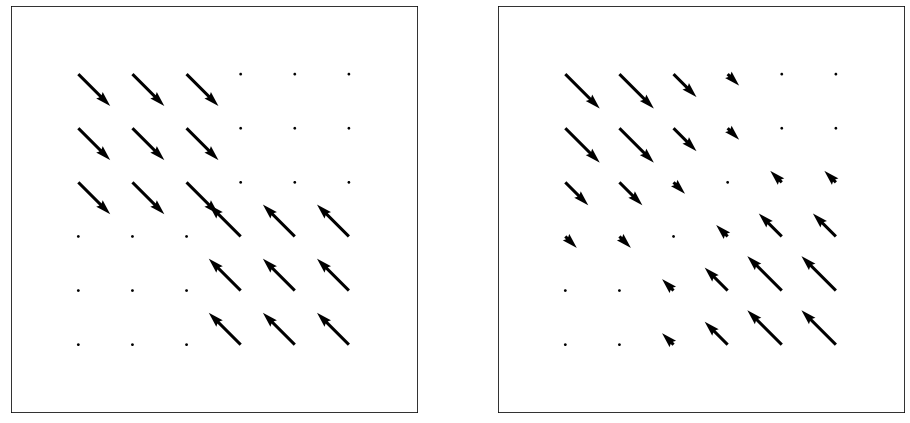

In [47]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_aspect('equal')
plt.quiver(u_test[::-1], v_test[::-1])
plt.margins(0.25, 0.25)

ax2 = fig.add_subplot(122)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_aspect('equal')
plt.quiver(loc_u[::-1], loc_v[::-1])
plt.margins(0.25, 0.25)
plt.show()

## 4. Iterative solution

Iteration step for a single frame.

In [26]:
def iteration_step(uv, e_x, e_y, e_t, alpha):
  u_loc = image_local_averages(uv[0])
  v_loc = image_local_averages(uv[1])
  uv_new = np.zeros_like(uv)
  uv_new[0] += u_loc - e_x*(e_x*u_loc + e_y*v_loc + e_t) / (alpha**2 + e_x**2 + e_y**2)
  uv_new[1] += v_loc - e_y*(e_x*u_loc + e_y*v_loc + e_t) / (alpha**2 + e_x**2 + e_y**2)
  return uv_new

Iteration for multiple frames.

In [60]:
def iteration(arr, n, alpha, uv_init=None, use_previous=False):
  """
  :param use_previous: if use_previous=True then the result of each time frame will be copied to the next time frame's iteration. Otherwise, uv_init will be used instead.
  """
  if uv_init is None:
    uv_init = np.zeros((2,) + arr.shape[:-1])
  
  uv = np.zeros_like(uv_init)
  uv += uv_init

  uv_final = np.zeros((2,) + arr.shape)

  e_x, e_y, e_t = image_seq_partial(arr)

  for t in range(arr.shape[-1]):
    for k in range(n):
      uv = iteration_step(uv, e_x[..., t], e_y[..., t], e_t[..., t], alpha=alpha)
    uv_final[..., t] += uv
    
    if not use_previous:
      uv = np.zeros_like(uv_init)
      uv += uv_init
  
  return uv_final

In [90]:
uv = iteration(im_arr, 10, alpha=10, use_previous=False)

In [91]:
uv.shape

(2, 6, 6, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


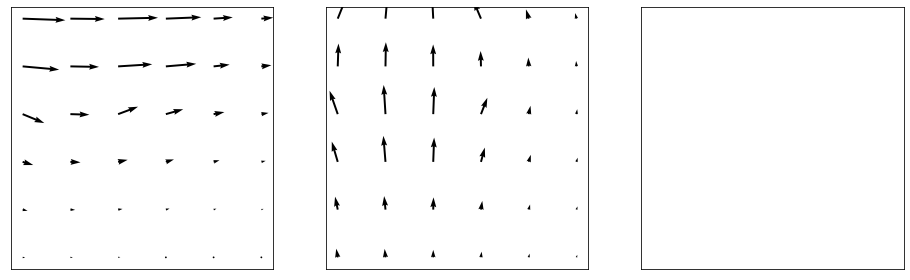

In [92]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(131)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_aspect('equal')
plt.quiver(uv[0, ::-1, :, 0], uv[1, ::-1, :, 0])

ax2 = fig.add_subplot(132)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_aspect('equal')
plt.quiver(uv[0, ::-1, :, 1], uv[1, ::-1, :, 1])

ax3 = fig.add_subplot(133)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_aspect('equal')
plt.quiver(uv[0, ::-1, :, 2], uv[1, ::-1, :, 2])

plt.show()